# Fallback - Retention Model Rollover
* StellarAlgo Data Science
* Grant Donst
* Oct 19, 2022

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.classification import *
from shared_utilities import helpers

In [68]:
CLUSTER = "prod-app"
DATABASE = "stlrnhlpanthers"
LKUPCLIENTID = "93"
TRAINING_YEAR = 2021
SCORING_YEAR = 2022

## Model Training

In [69]:
df = helpers.get_retention_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    start_year=TRAINING_YEAR,
    end_year=SCORING_YEAR
)

df.shape

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(5238, 24)

In [70]:
# choose the features for the stellar base retention model
features = [
    "recentdate",
	"clientcode",
	"dimcustomermasterid",
	"lkupclientid",
	"productgrouping",
	"year",
	"attendancepercent",
	"disttovenue",
    "inperson_contact",
	"missed_games_1",
	"missed_games_2",
	"missed_games_over_2",
	"recency",
	"source_tenure",
	"totalspent",
	"isnextyear_buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= TRAINING_YEAR]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (4452, 16)
Unseen Data For Predictions: (786, 16)



In [71]:
setup(
    data= df_train, 
    target="isnextyear_buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentdate"
    ],
    ignore_features=[
        "clientcode",
		"dimcustomermasterid",
		"lkupclientid",
		"productgrouping",
		"year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancepercent",
		"disttovenue",
        "inperson_contact",
		"missed_games_1",
		"missed_games_2",
		"missed_games_over_2",
		"recency",
		"source_tenure",
		"totalspent"
    ]
);

In [72]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8628,0.9317,0.7514,0.8633,0.8027,0.6984,0.7031,0.0200


In [73]:
best_model = create_model(model_matrix);
final_model = finalize_model(best_model);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8628,0.9311,0.7021,0.9083,0.7920,0.6921,0.7049
1,0.8865,0.9478,0.8085,0.8769,0.8413,0.7533,0.7548
2,0.8707,0.9368,0.7872,0.8538,0.8192,0.7188,0.7203
3,0.8681,0.9344,0.7660,0.8640,0.8120,0.7110,0.7140
4,0.8492,0.9376,0.7730,0.8134,0.7927,0.6743,0.6749
5,0.8413,0.9182,0.7092,0.8403,0.7692,0.6496,0.6550
6,0.8810,0.9438,0.8014,0.8692,0.8339,0.7414,0.7429
7,0.8386,0.9211,0.7021,0.8390,0.7645,0.6432,0.6491
8,0.8862,0.9312,0.7571,0.9217,0.8314,0.7468,0.7550


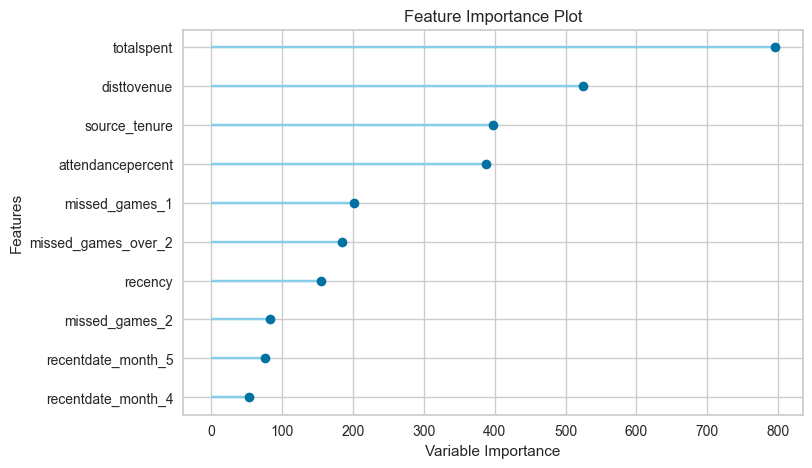

In [74]:
plot_model(final_model, plot='feature')

## Model Inference

### Let's load in our inference data and get retention scores using the model:

In [75]:
df_inference = df.loc[df["year"] >= SCORING_YEAR]
#df_inference = df_inference.fillna(0)

# remove the target column from the inference df
df_inference = df_inference[features]
df_inference = df_inference.drop(columns=["isnextyear_buyer"], axis=1)

df_inference.shape

(0, 15)

In [76]:
df_scores = predict_model(final_model, data=df_inference, raw_score=True)

ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required.

Text(0.5, 1.0, 'RETENTION SCORES:      PROD-APP     STLRNHLPANTHERS')

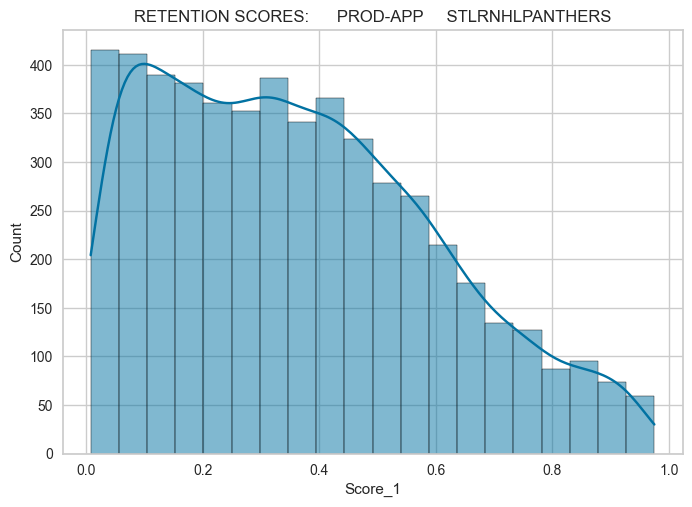

In [ ]:
sns.histplot(data=df_scores, x='Score_1', bins= 20, kde=True)    
plt.title(f"RETENTION SCORES:      {CLUSTER.upper()}     {DATABASE.upper()}", fontsize = 12)